# Speech Emotion Recognition with ConvNet and MFCCs

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

# Getting Dataset

In [2]:
#TESS dataset
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('TESS Toronto emotional speech set data'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        duration.append(round(librosa.get_duration(filename=paths[-1]), 3))
        
        label = filename[::-1].split('_')[0][::-1]
        labels.append(label[:-4].lower())

df_tess = pd.DataFrame({'path':paths,'duration': duration, 'dataset': 'TESS', 'emotion':labels})

df_tess['emotion'] = df_tess['emotion'].replace(['ps'], 'surprise')
                  


In [3]:
df_tess.sample(5)

,path,duration,dataset,emotion
2524,TESS Toronto emotional speech set data\TESS To...,1.832,TESS,surprise
1602,TESS Toronto emotional speech set data\TESS To...,2.497,TESS,disgust
5062,TESS Toronto emotional speech set data\YAF_neu...,2.105,TESS,neutral
4138,TESS Toronto emotional speech set data\TESS To...,2.357,TESS,sad
4819,TESS Toronto emotional speech set data\YAF_hap...,1.934,TESS,happy


In [4]:
#RAVDESS dataset
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('RAVDESS archive'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        duration.append(round(librosa.get_duration(filename=paths[-1]), 3)) 
        
        label = filename[::-1].split('_')[0][::-1]
        
        if label[6:8] == '01':
            labels.append('neutral')
        elif label[6:8] == '02':
            labels.append('calm')
        elif label[6:8] == '03':
            labels.append('happy')
        elif label[6:8] == '04':
            labels.append('sad')
        elif label[6:8] == '05':
            labels.append('angry')
        elif label[6:8] == '06':
            labels.append('fear')
        elif label[6:8] == '07':
            labels.append('disgust')
        elif label[6:8] == '08':
            labels.append('surprise')       

df_ravdess = pd.DataFrame({'path':paths,'duration': duration, 'dataset': 'RAVDESS', 'emotion':labels})

In [5]:
df_ravdess.sample(5)

,path,duration,dataset,emotion
678,RAVDESS archive\Actor_12\03-01-03-02-02-01-12.wav,3.904,RAVDESS,happy
1435,RAVDESS archive\Actor_24\03-01-08-01-02-02-24.wav,3.403,RAVDESS,surprise
1995,RAVDESS archive\audio_speech_actors_01-24\Acto...,3.337,RAVDESS,happy
803,RAVDESS archive\Actor_14\03-01-04-01-02-02-14.wav,3.537,RAVDESS,sad
623,RAVDESS archive\Actor_11\03-01-04-01-02-02-11.wav,3.437,RAVDESS,sad


In [6]:
#concatenating both dataset
df = pd.concat([df_tess, df_ravdess])

# Dropping 'calm' as out the scope (also not many samples)
df = df[df['emotion'].str.contains('calm') == False].reset_index(drop=True)

print('The dataset has {} audio files. Below printed 5 random entries:'.format(df.shape[0]))

df.sample(5)

The dataset has 8096 audio files. Below printed 5 random entries:


,path,duration,dataset,emotion
4419,TESS Toronto emotional speech set data\YAF_dis...,2.655,TESS,disgust
572,TESS Toronto emotional speech set data\OAF_Fea...,1.462,TESS,fear
7271,RAVDESS archive\audio_speech_actors_01-24\Acto...,3.470,RAVDESS,happy
4361,TESS Toronto emotional speech set data\YAF_ang...,2.025,TESS,angry
8056,RAVDESS archive\audio_speech_actors_01-24\Acto...,4.104,RAVDESS,sad


# Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8096 entries, 0 to 8095
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   path      8096 non-null   object 
 1   duration  8096 non-null   float64
 2   dataset   8096 non-null   object 
 3   emotion   8096 non-null   object 
dtypes: float64(1), object(3)
memory usage: 253.1+ KB


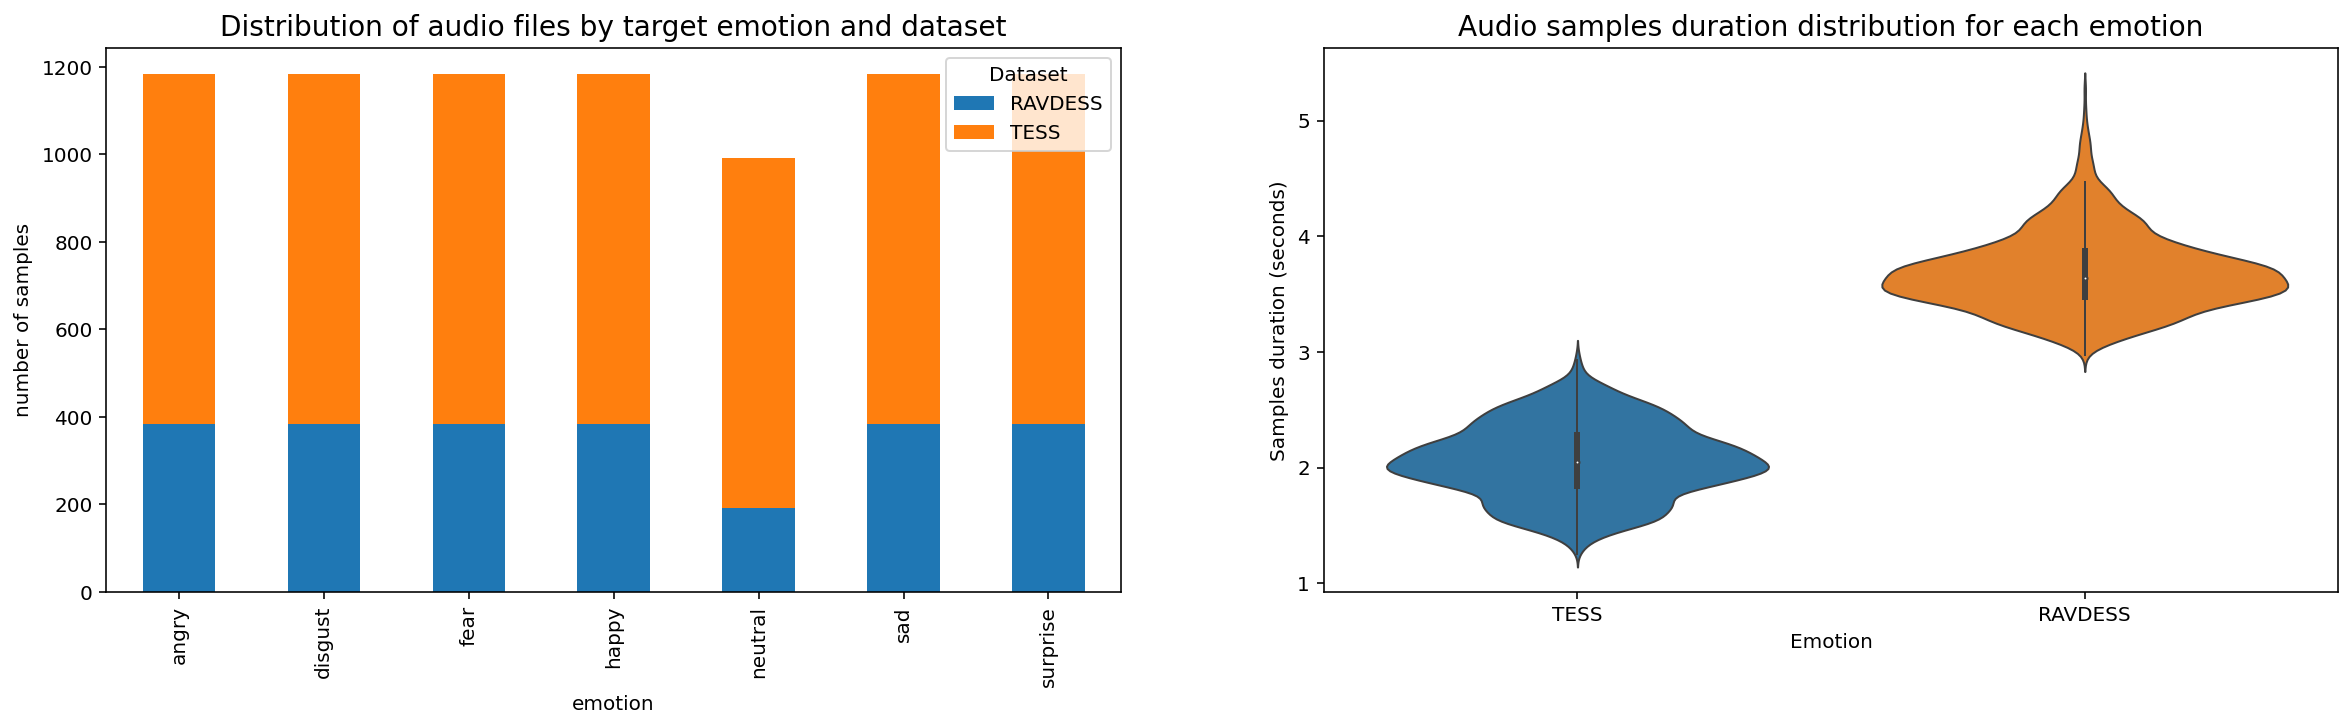

In [8]:
# figure (2 subplots)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

#checking sample distribution
df.groupby(['emotion','dataset']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Distribution of audio files by target emotion and dataset', size=14)
axes[0].set_ylabel('number of samples')
axes[0].legend(title='Dataset')

# Check duration distribution by each source using violin plots
sns.violinplot(x=df['dataset'],y=df['duration'], linewidth=1, ax=axes[1])
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Samples duration (seconds)')
axes[1].set_title('Audio samples duration distribution for each emotion', size=14)

plt.show()

In [9]:
import random
# function to display samples information by emotion
def show_audio(emotion):
    # creating sublots
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
    # filter dataframe to emotion
    df_show = df.loc[df['emotion'] == emotion].reset_index(drop=True)
    index = random.randint(0, df_show.shape[0])
    
    # load audio file:
    y, sr = librosa.load(df_show.path[index], sr=16000)
        
    # Show waveform
    librosa.display.waveshow(y, sr=sr, ax=axs[0])
    axs[0].set_title('Waveform')
    
    # Extract fundamental frequency (f0) using a probabilistic approach
    f0, _, _ = librosa.pyin(y, sr=sr, fmin=50, fmax=1500, frame_length=2048)

    # Establish timepoint of f0 signal
    timepoints = np.linspace(0, df_show.duration[index], num=len(f0), endpoint=False)
    
    # Compute short-time Fourier Transform
    x_stft = np.abs(librosa.stft(y))
    
    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
    
    # Plot STFT spectrogram
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=axs[1])
    
    # Plot fundamental frequency (f0) in spectrogram plot
    axs[1].plot(timepoints, f0, color="cyan", linewidth=4)
    axs[1].set_title('Spectrogram with fundamental frequency')
    
    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    x_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # Plot MFCCs
    librosa.display.specshow(x_mfccs, sr=sr, x_axis="time", norm=Normalize(vmin=-50, vmax=50), ax=axs[2])
    axs[2].set_title('MFCCs')
    
    # Show metadata in title
    plt.suptitle('File: {}  -  Emotion: {}'.format(df_show.path[index], df_show.emotion[index]), size=14)
    plt.tight_layout()
    plt.show()
    
    # Display media player for the selected file
    display(ipd.Audio(y, rate=sr)) 

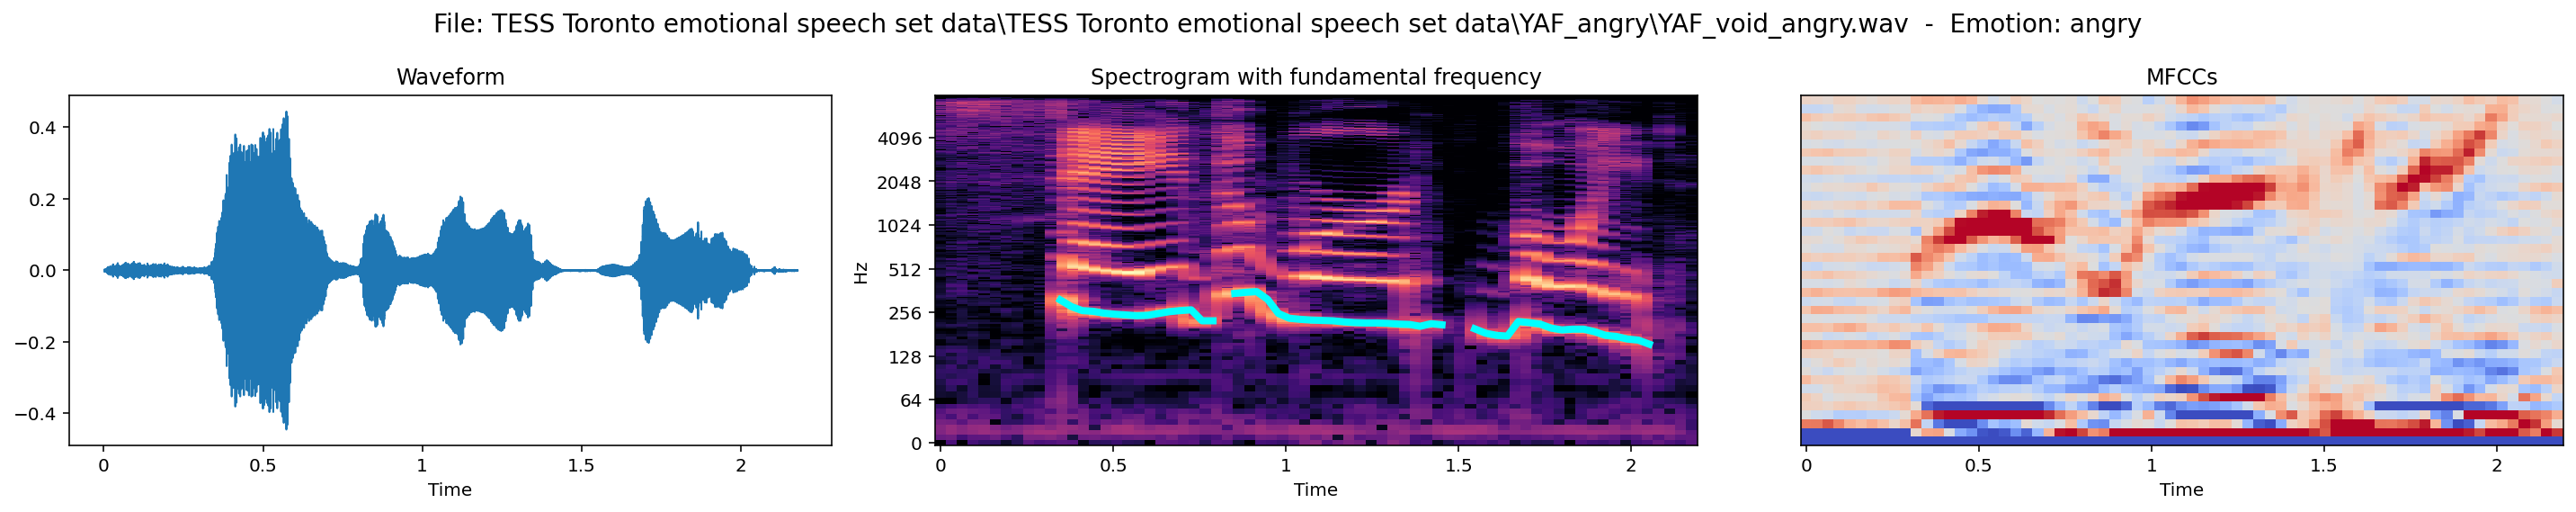

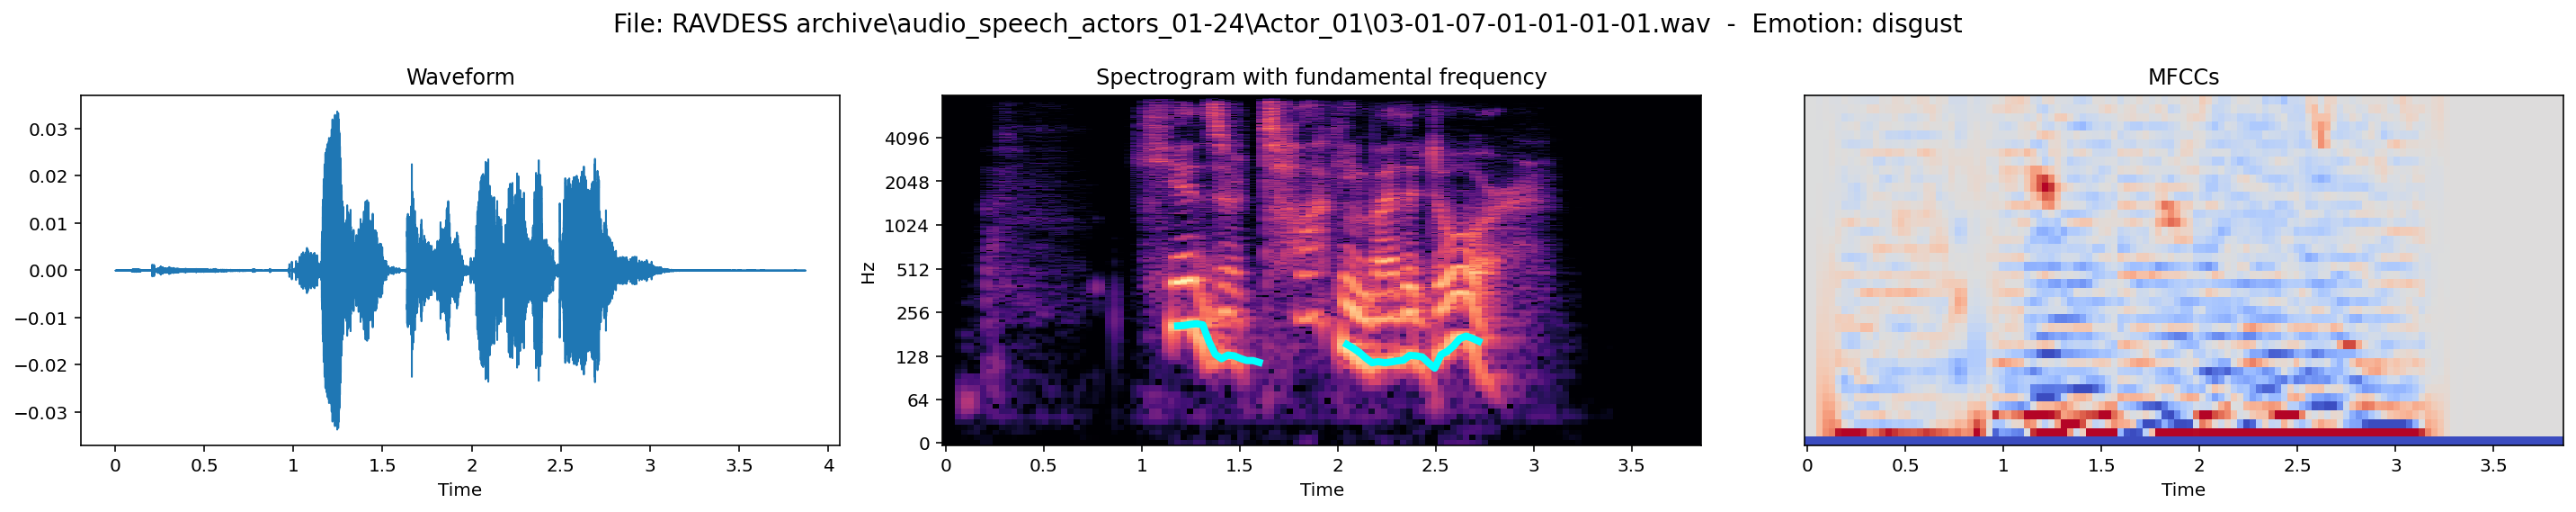

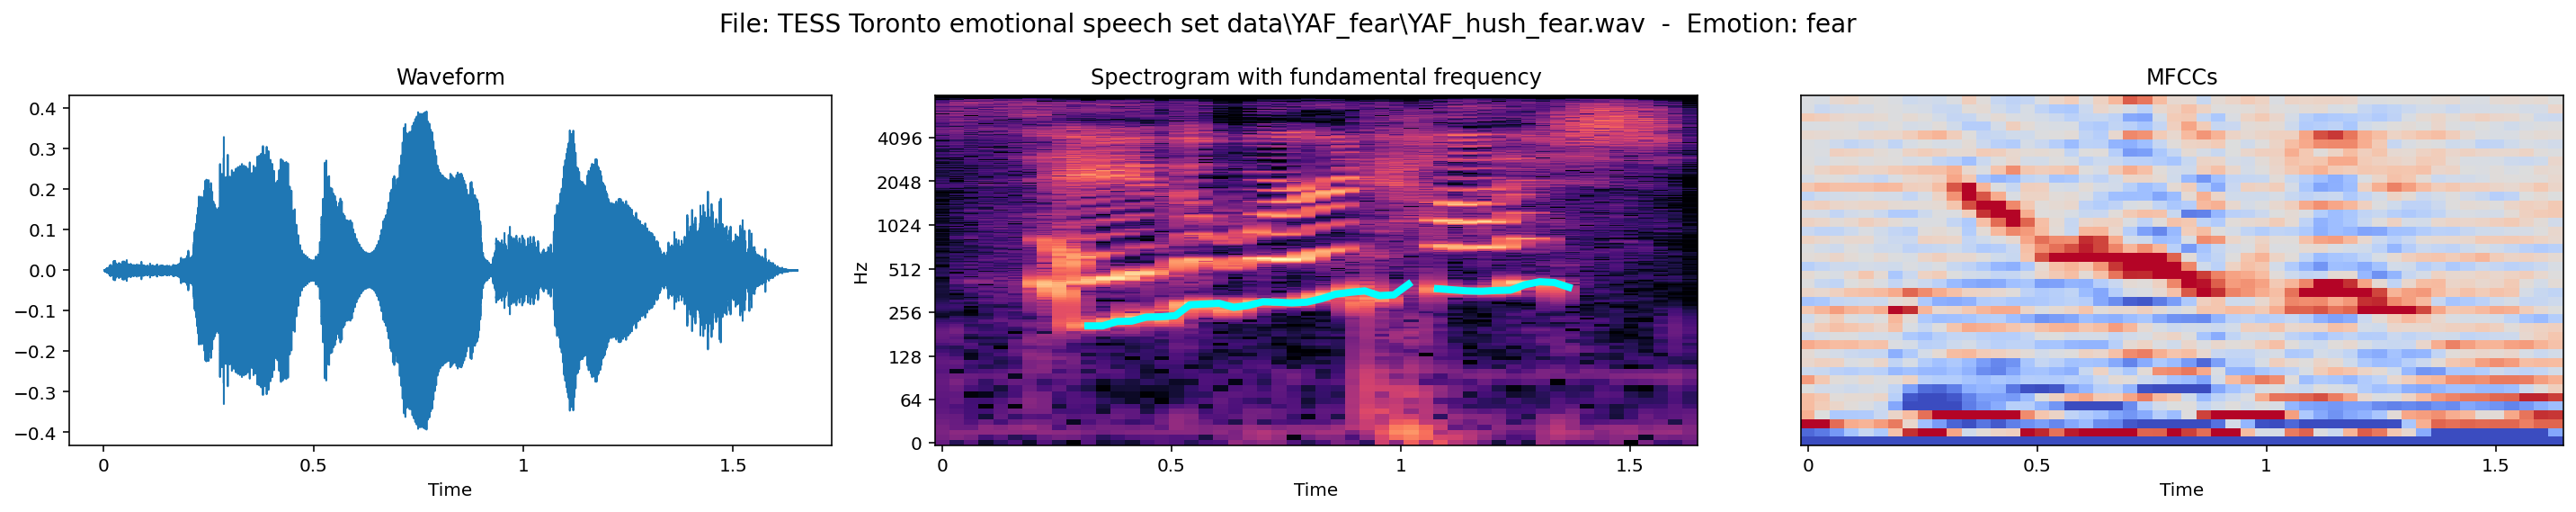

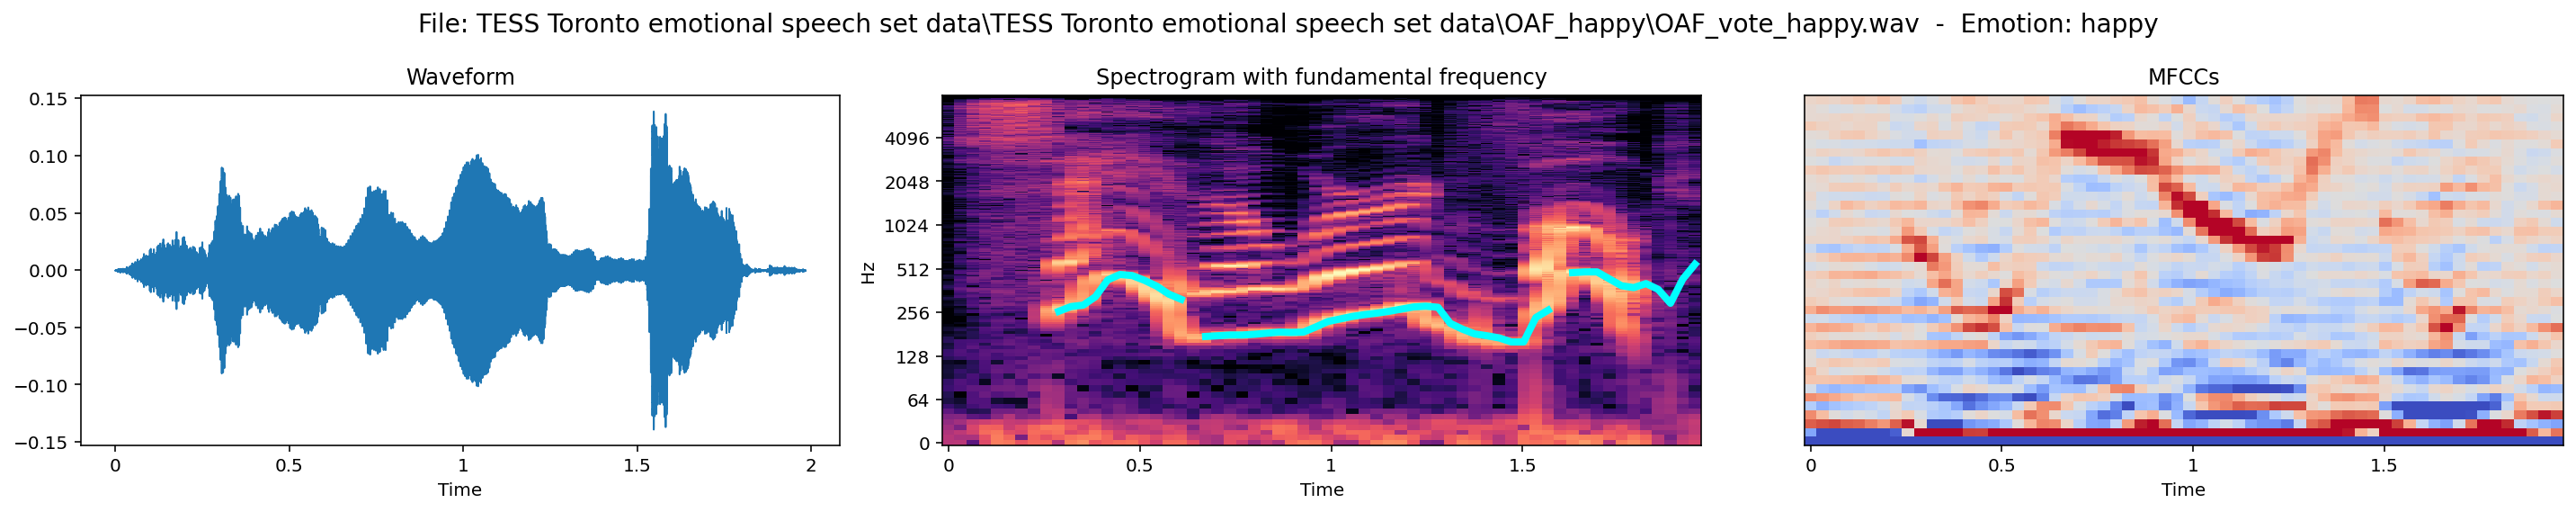

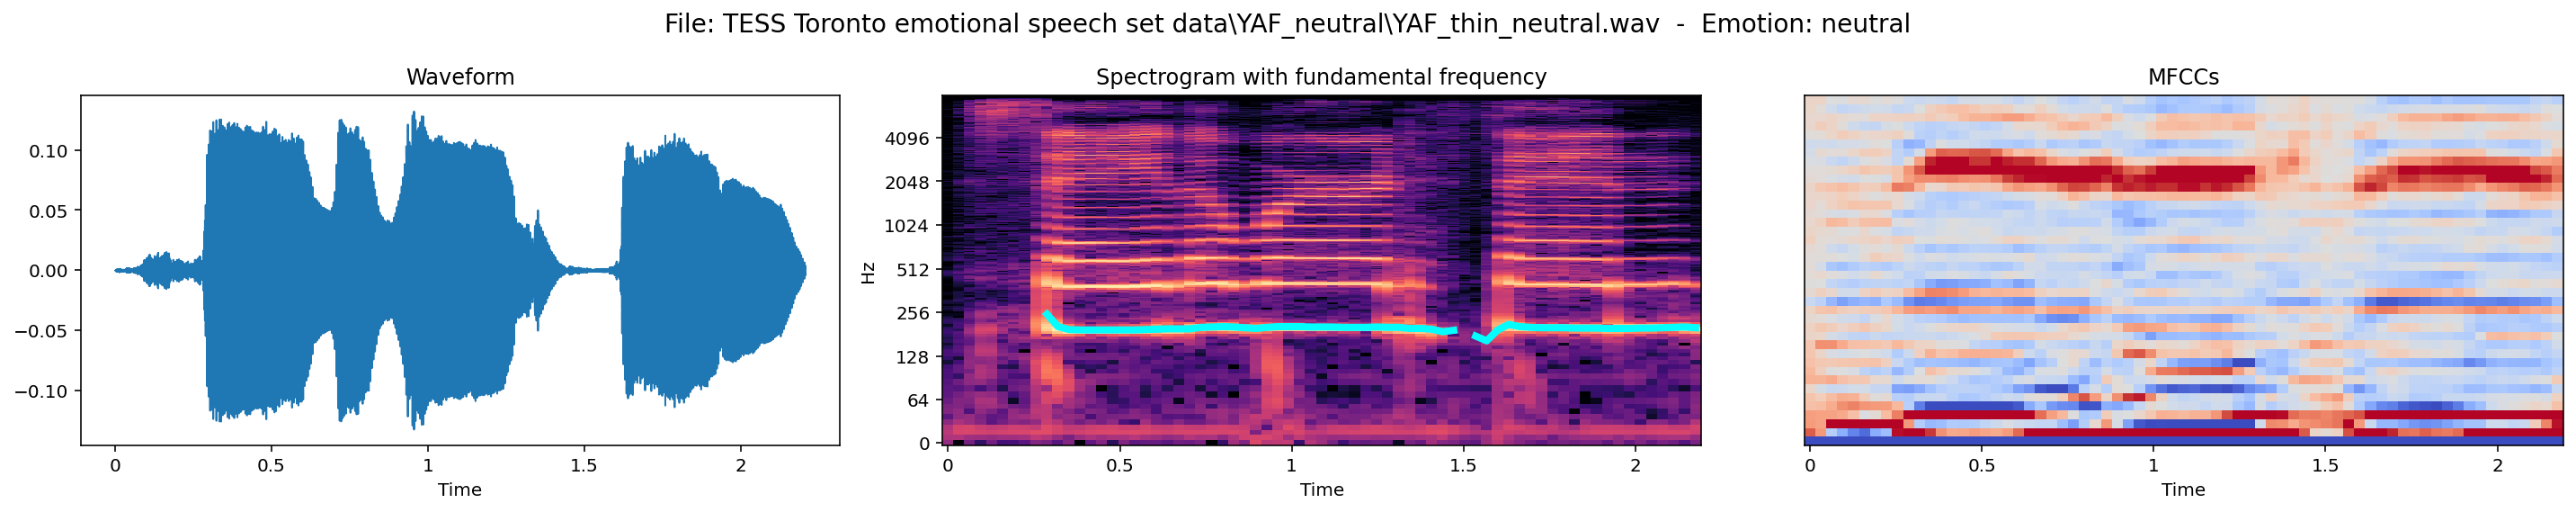

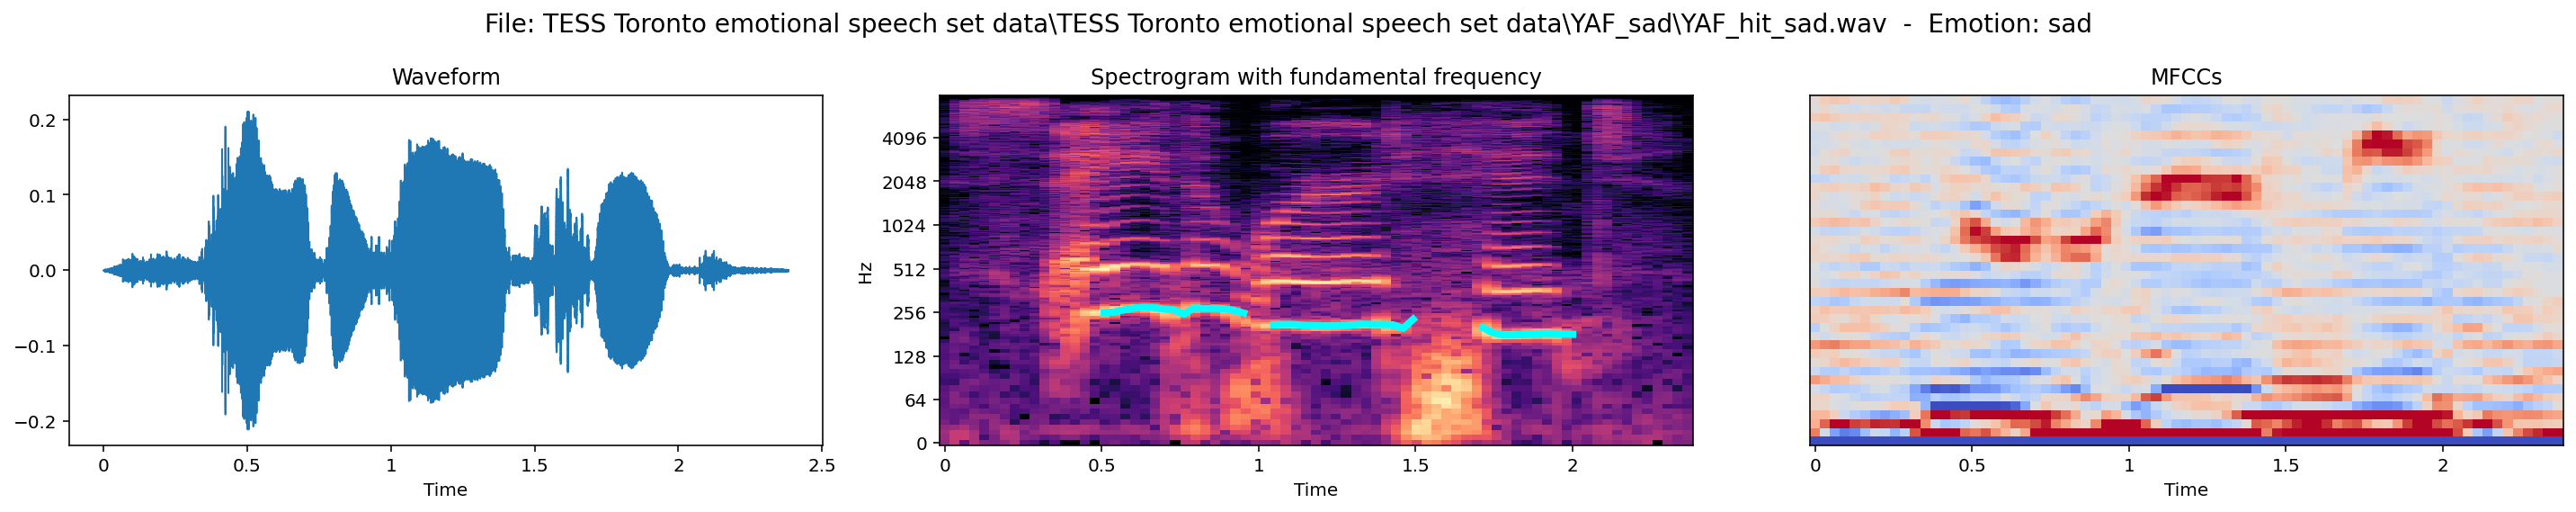

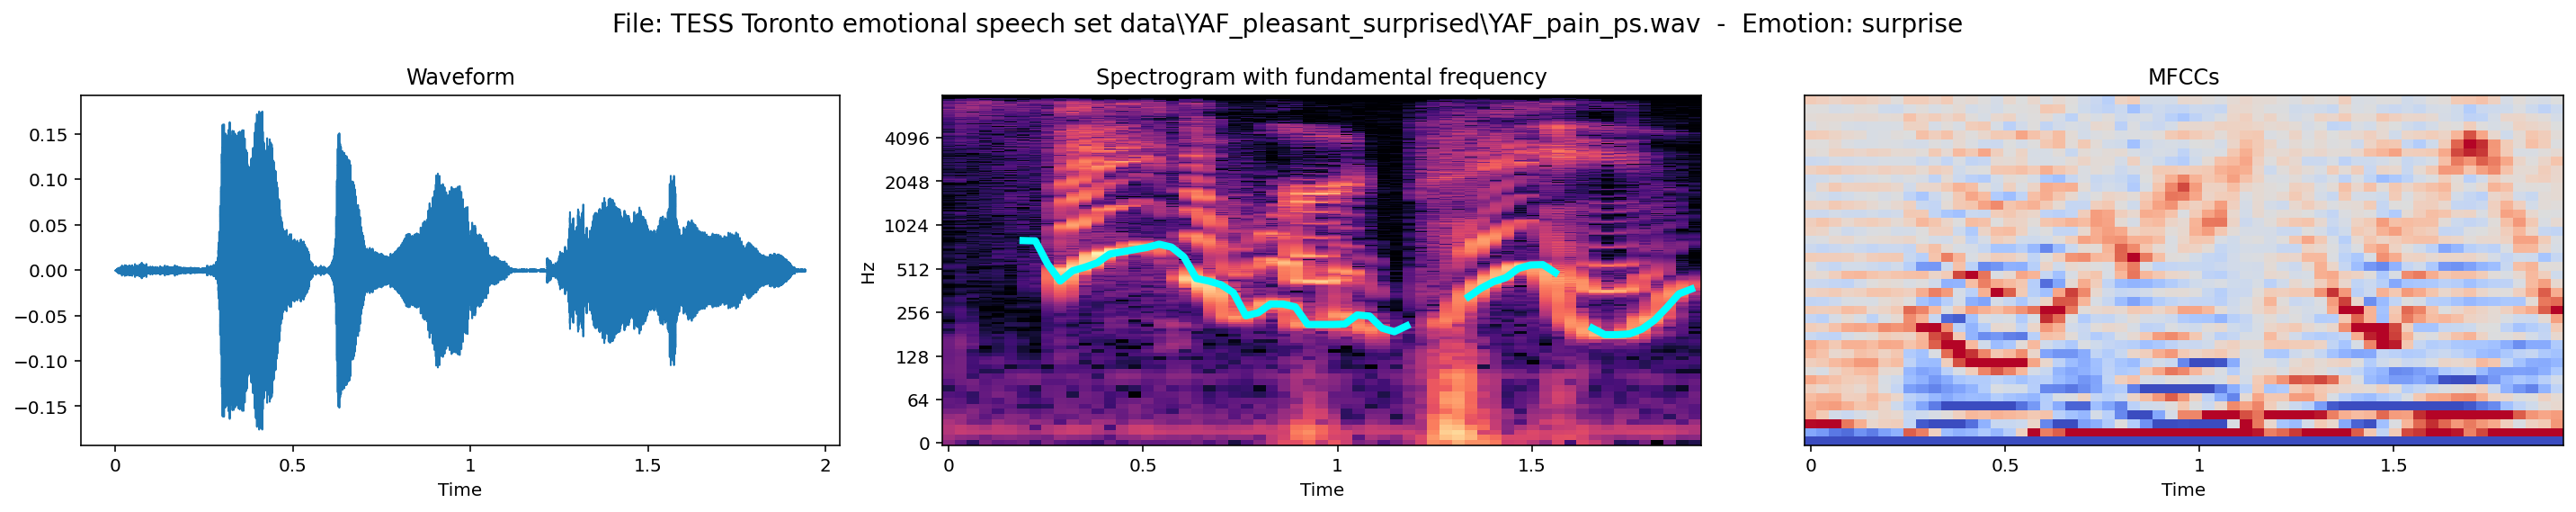

In [10]:
emotions = sorted(list(df.emotion.unique()))
# Get waveforms, spectograms, mfccs and media player for each emotion
for emotion in emotions:
    show_audio(emotion)

# MFCCs

In [11]:
%%time

mfccs = [] # variable to store the mfccs data

for file in df.path:
    # load audio file:
    y, sr = librosa.load(file, sr=16000)
    
    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    mfccs.append(librosa.feature.mfcc(y=y, sr=sr, fmin=50, n_mfcc=30))

Wall time: 9min 59s


In [12]:
# function to resize the 2D arrays
def resize_array(array):
    new_matrix = np.zeros((30,150))   
    for i in range(30):             
        for j in range(150):
            try:                                 
                new_matrix[i][j] = array[i][j]
            except IndexError: 
                pass
    return new_matrix


resized_mfccs = [] # variable to store the new resized mfccs and apply function for all the extracted mfccs

for mfcc in mfccs:
    resized_mfccs.append(resize_array(mfcc))

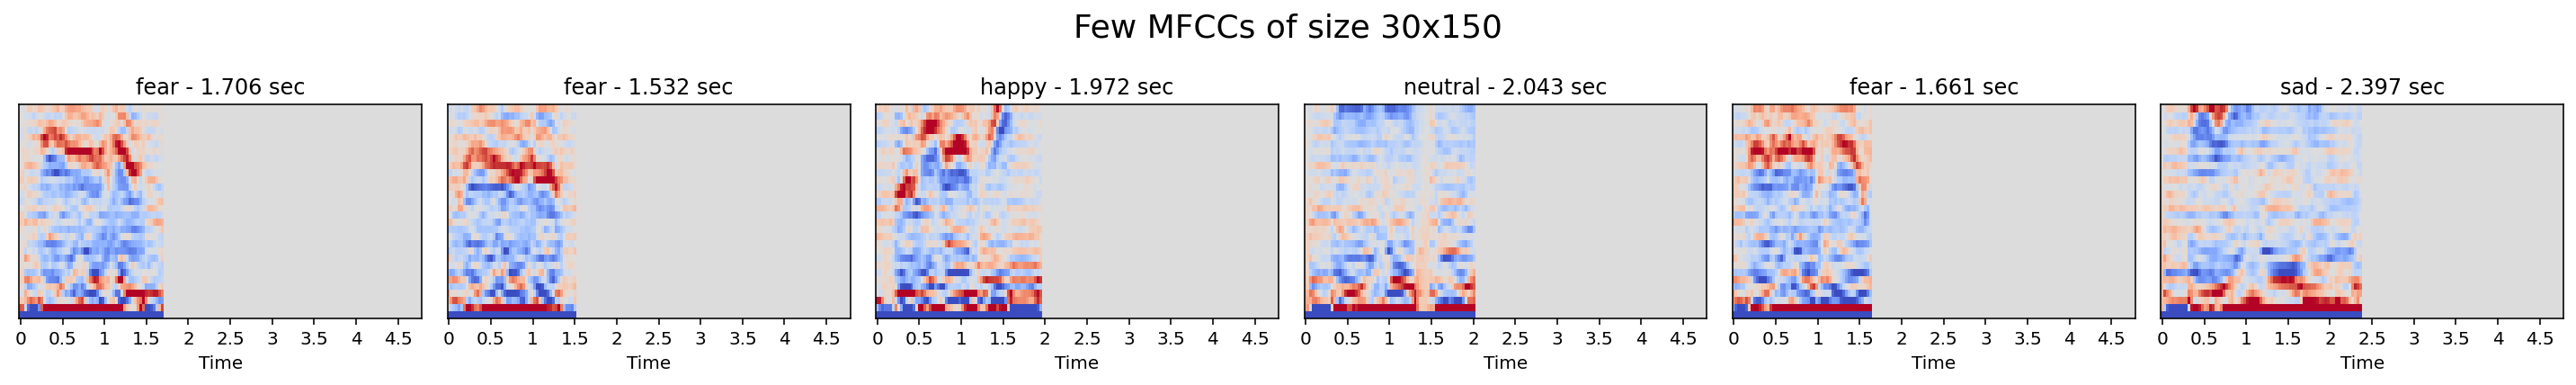

In [13]:
# visualizing few random MFCCs with the new shape
fig, axs = plt.subplots(nrows=1,ncols=6, figsize=(20,3))

# Selecting 6 random MFCCs
for i in range(6):
    index = random.randint(0, len(resized_mfccs))
    
    # Plot MFCCs
    librosa.display.specshow(resized_mfccs[index], sr=sr, x_axis="time", ax=axs[i], norm=Normalize(vmin=-50, vmax=50))
    axs[i].set_title(str(df.emotion[index]) + ' - ' + str(df.duration[index]) + ' sec')

plt.suptitle('Few MFCCs of size 30x150', size=18)
plt.tight_layout()
plt.show()

#  Convolutional Neural Network model

###### Splitting dataset into training and test set

In [14]:
from sklearn.model_selection import train_test_split

# Select target
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
y = df.emotion.values

# Features
X = resized_mfccs.copy()

# Create train, validation and test set
x_tr, x_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.3, shuffle=True, random_state=0)

# Convert data to numpy arrays
x_tr = np.array([i for i in x_tr])
x_va = np.array([i for i in x_va])
x_te = np.array([i for i in x_te])

# Plot size of data
print(x_tr.shape)
print(x_va.shape)
print(x_te.shape)

(5100, 30, 150)
(2186, 30, 150)
(810, 30, 150)


In [15]:
# Get mean and standard deviation from the training set
tr_mean = np.mean(x_tr, axis=0)
tr_std = np.std(x_tr, axis=0)

# Apply data scaling
x_tr = (x_tr - tr_mean)/tr_std
x_va = (x_va - tr_mean)/tr_std
x_te = (x_te - tr_mean)/tr_std

In [16]:
# Necessary operation is to add another 'dimension' to the data:
print(f"x_tr has a dimension of {x_tr.shape} before the manipulation.")

x_tr = x_tr[..., None]
x_va = x_va[..., None]
x_te = x_te[..., None]

print(f"x_tr has a dimension of {x_tr.shape} after the manipulation.")

x_tr has a dimension of (5100, 30, 150) before the manipulation.
x_tr has a dimension of (5100, 30, 150, 1) after the manipulation.


###### Convolution Neural Network Model using Tensorflow

In [17]:
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D)
from tensorflow.keras import initializers

# Create convolutional neural network and return summary
model = keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=5, strides=(2, 2), activation="relu", input_shape=x_tr.shape[1:]))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=4, strides=(2, 1), activation="relu"))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=7, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 73, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 36, 64)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 6, 36, 64)         256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 33, 32)         32800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 16, 32)         0         
 g2D)                                                            
                                                        

In [18]:
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=5)

In [19]:
%%time

#  Train the neural network
history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=32,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb]
)

Epoch 1/100
160/160 [==============================] - 8s 40ms/step - loss: 2.1081 - accuracy: 0.2761 - val_loss: 1.5405 - val_accuracy: 0.6029
Epoch 2/100
160/160 [==============================] - 6s 39ms/step - loss: 1.2438 - accuracy: 0.5516 - val_loss: 0.7707 - val_accuracy: 0.7548
Epoch 3/100
160/160 [==============================] - 7s 46ms/step - loss: 0.8713 - accuracy: 0.6759 - val_loss: 0.6029 - val_accuracy: 0.7690
Epoch 4/100
160/160 [==============================] - 9s 58ms/step - loss: 0.7739 - accuracy: 0.7133 - val_loss: 0.5905 - val_accuracy: 0.7827
Epoch 5/100
160/160 [==============================] - 8s 51ms/step - loss: 0.6895 - accuracy: 0.7416 - val_loss: 0.5560 - val_accuracy: 0.7960
Epoch 6/100
160/160 [==============================] - 7s 43ms/step - loss: 0.6592 - accuracy: 0.7520 - val_loss: 0.5467 - val_accuracy: 0.7978
Epoch 7/100
160/160 [==============================] - 7s 47ms/step - loss: 0.6254 - accuracy: 0.7586 - val_loss: 0.5499 - val_accuracy:

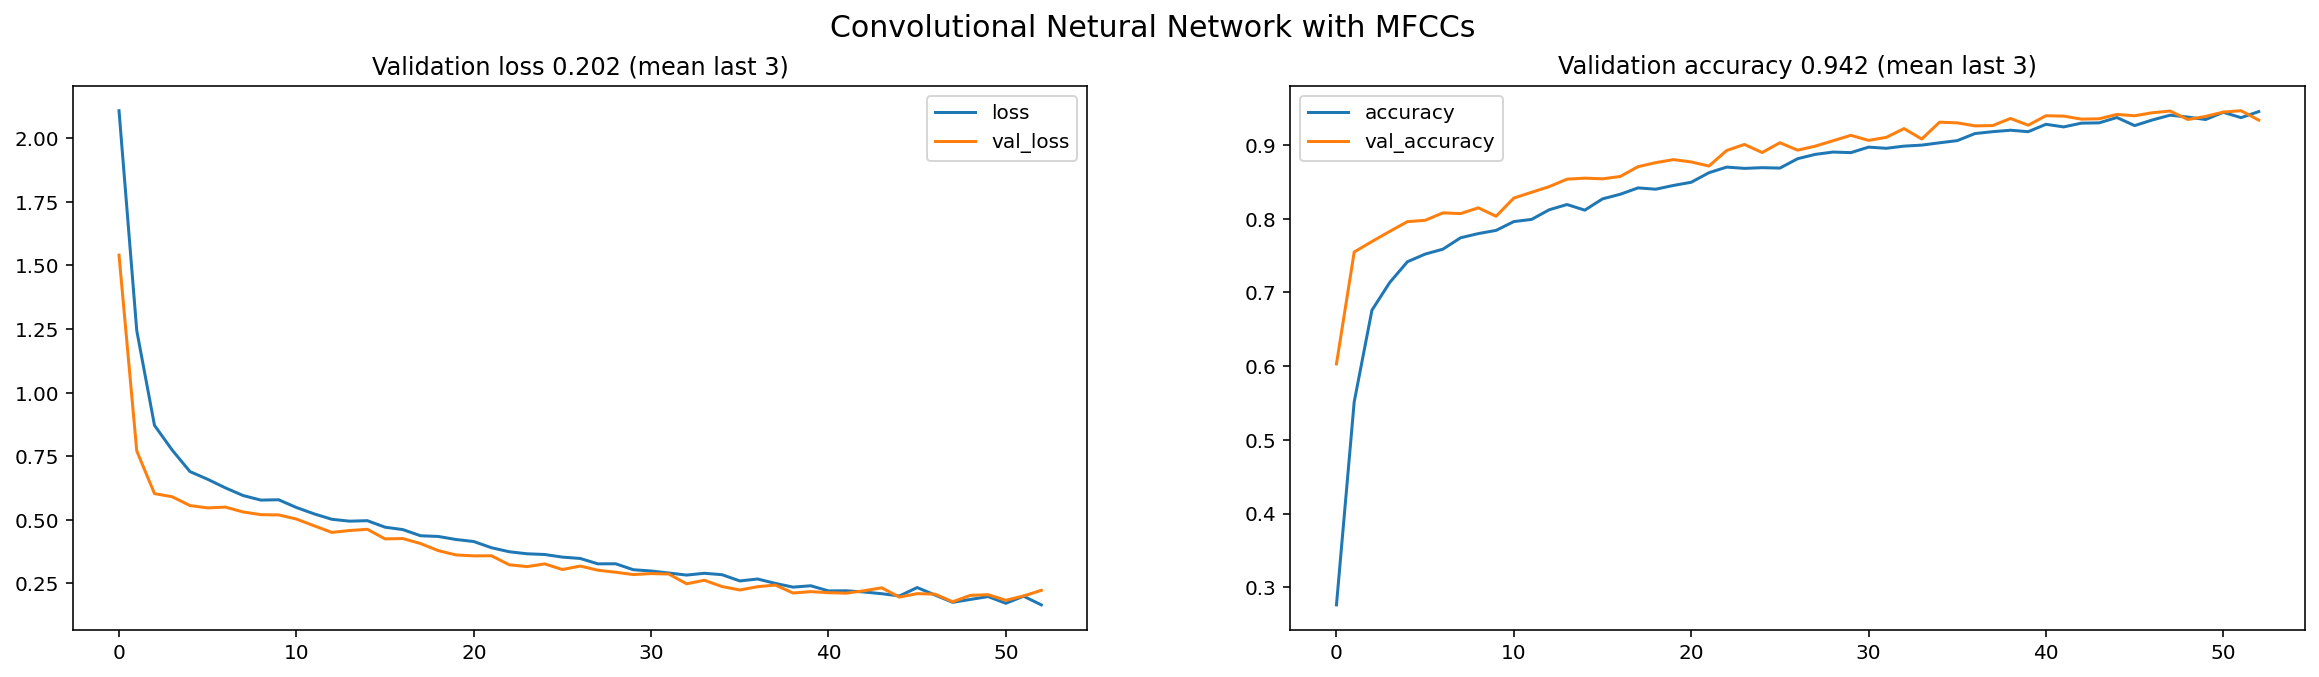

In [20]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.show()

###### Test set Evaluation

In [21]:
loss_te, accuracy_te = model.evaluate(x_te, y_te)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

26/26 [==============================] - 0s 8ms/step - loss: 0.1991 - accuracy: 0.9321
Test loss: 0.20
Test accuracy: 93.21%


26/26 [==============================] - 0s 7ms/step


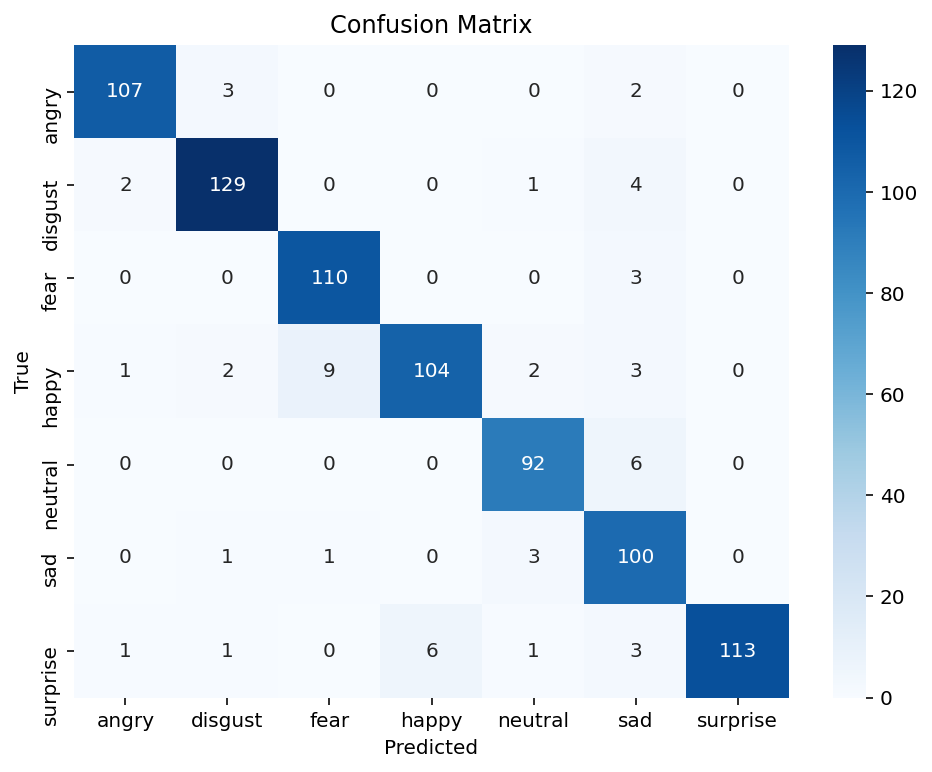

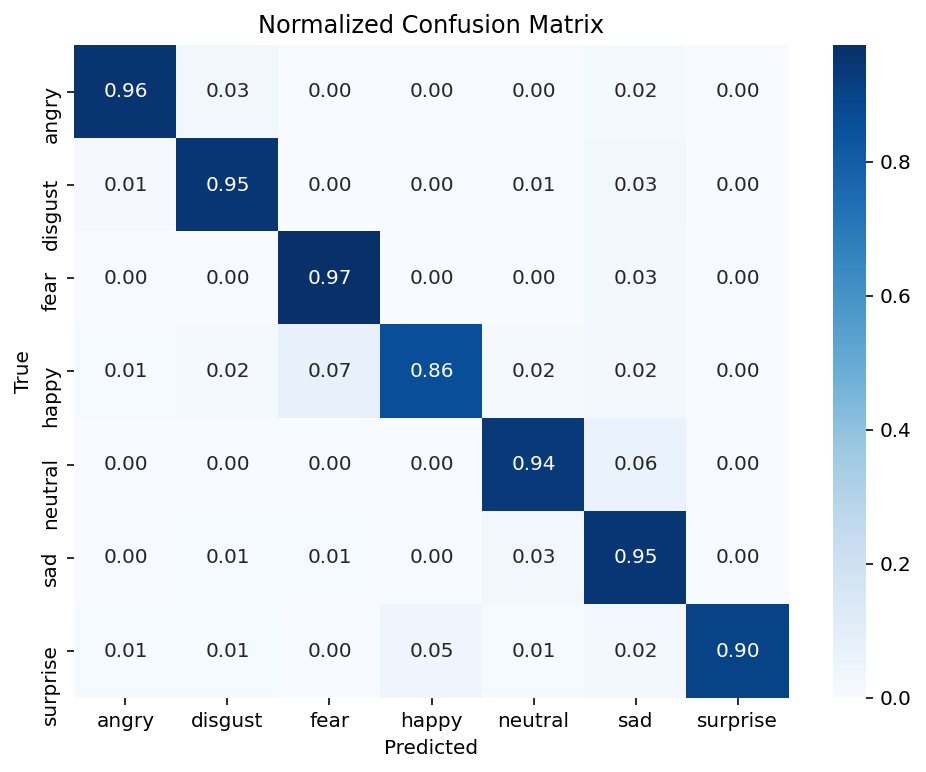

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_true contains the true labels and y_pred contains the predicted labels

# Create a heatmap for the confusion matrix


def plot_confusion_matrices(y_true, y_pred):
    labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    

predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))



# Plot confusion matrices
plot_confusion_matrices(y_te, pred)